**Mount the Drive**

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports and Configs

**Imports**

In [2]:
# Deafault Imports
import os
import logging
import functools
import warnings as wr
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tkl
from keras import models as tkm
from keras.preprocessing.image import ImageDataGenerator, random_shear, random_shift
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

!wget https://storage.googleapis.com/storage.barbiero.dev/public_data_clean.npz

--2023-11-12 18:59:19--  https://storage.googleapis.com/storage.barbiero.dev/public_data_clean.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 536546306 (512M) [application/octet-stream]
Saving to: ‘public_data_clean.npz’

public_data_clean.n 100%[===================>] 511.69M  12.0MB/s    in 43s     

2023-11-12 19:00:04 (11.8 MB/s) - ‘public_data_clean.npz’ saved [536546306/536546306]



**Randomnes and Configurations**

In [3]:
# Names
NAME_MODEL = "ConvNeXt_8k"
NAME_PLOT = NAME_MODEL + "_plot"
NAME_CMATRIX = NAME_MODEL + "_cmatrix"

# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**Defining Functions**

In [78]:
# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()
def plot_confusion_matrix(model, test, test_lbls, figsize, name_jpg):
  # Compute the confusion matrix
  tp = model.predict(test, verbose=0)
  cm = confusion_matrix(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1))

  # Compute classification metrics
  accuracy = accuracy_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1))
  precision = precision_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')
  recall = recall_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')
  f1 = f1_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')

  # Display the computed metrics
  print('Accuracy:\t', accuracy.round(4))
  print('Precision:\t', precision.round(4))
  print('Recall:\t\t', recall.round(4))
  print('F1:\t\t', f1.round(4))

  # Plot the confusion matrix
  lbls = ["Unhealthy", "Healthy"]
  plt.figure(figsize=figsize, dpi=200)
  sns.heatmap(cm.T, annot=True, cmap='Blues', xticklabels=lbls, yticklabels=lbls)
  plt.xlabel('Labels', fontsize=6)
  plt.xticks(fontsize=8)
  plt.ylabel('Predicted Labels', fontsize=6)
  plt.yticks(fontsize=8)
  plt.savefig(name_jpg)
  plt.show()
def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")

# Data Agumentation Functions
def pick_random_label(i, lbls, lbl):
  if lbls[i] == lbl:
    return True
  else:
    return False
def manual_augmentation(imgs, lbls, string_lbls):
  cardinality = pd.DataFrame(string_lbls, columns=['class'])['class'].value_counts()       # Store the Cardinality of the SETS "healthy", "unhealthy"
  ch = cardinality['healthy']
  cu = cardinality['unhealthy']
  diff = ch-cu
  print(cardinality)

  i_arr = []
  ROWS = 2
  COLS = 4
  augm = []
  augm_lbl = []

  if diff > 0:
    print("Augment the Unhealthy with ", diff, "new images")
    for z in range(int(diff/7)):
      index = rnd.randint(0, len(lbls)-1)
      while not pick_random_label(index, string_lbls, "unhealthy") or index in i_arr:
        i_arr.append(index)
        index = rnd.randint(0, len(lbls)-1)

      if string_lbls[index] == "unhealthy":
        i_arr.append(index)
        img = imgs[index]
        for row in range(ROWS):
            for col in range(COLS):
                img = np.rot90(img)
                if row==0 and col==3:
                    continue
                augm.append(img)
                augm_lbl.append(lbls[index])
            if row == 0:
                img = np.flipud(img)
  else:
    print("Augment the Healthy with ", diff, "new images")
    for z in range(int(-diff/7)):
      index = rnd.randint(0, len(lbls)-1)
      while not pick_random_label(index, string_lbls, "unhealthy") or index in i_arr:
        i_arr.append(index)
        index = rnd.randint(0, len(lbls)-1)

      if string_lbls[index] == "unhealthy":
        i_arr.append(index)
        img = imgs[index]
        for row in range(ROWS):
            for col in range(COLS):
                img = np.rot90(img)
                if row==0 and col==3:
                    continue
                augm.append(img)
                augm_lbl.append(lbls[index])
            if row == 0:
                img = np.flipud(img)

  # augm_lbl = list(map(lambda x: 0 if x == "healthy" else 1, augm_lbl))
  # augm_lbl = tfk.utils.to_categorical(augm_lbl, len(np.unique(LBLS)))

  augm = np.array(augm)
  augm_lbl = np.array(augm_lbl)

  imgs = np.concatenate((imgs, augm), axis=0)
  lbls = np.concatenate((lbls, augm_lbl), axis=0)
  print()

  return imgs, lbls

def mixup(img_a, img_b, lbl_a, lbl_b, alpha=0.5):
  lmb = rnd.uniform(0.1, 0.25) if rnd.choice([True, False]) else rnd.uniform(0.75, 0.9)

  mixed_img = np.uint8(lmb*img_a + (1-lmb)*img_b)
  mixed_lbl = lmb*lbl_a + (1-lmb)*lbl_b

  return mixed_img, mixed_lbl
def increase_volume_mixup(imgs, lbls, size):
  indices = []
  augm_lbls = []
  augm_imgs = []

  for i in range(size):
    index = rnd.randint(0, len(lbls)-1)
    while index in indices:
      index = rnd.randint(0, len(lbls)-1)
    indices.append([index])

    if np.argmax(lbls[index]):
      index_2 = rnd.randint(0, len(lbls)-1)
      while [index, index_2] in indices or  np.argmax(lbls[index_2]):
        index_2 = rnd.randint(0, len(lbls)-1)
      indices[i].append(index_2)
    elif not np.argmax(lbls[index]):
      index_2 = rnd.randint(0, len(lbls)-1)
      while [index, index_2] in indices or not np.argmax(lbls[index_2]):
        index_2 = rnd.randint(0, len(lbls)-1)
      indices[i].append(index_2)

    aug_img, aug_lbl = mixup(imgs[index], imgs[index_2], lbls[index], lbls[index_2])
    augm_imgs.append(aug_img)
    augm_lbls.append(aug_lbl)


  augm_lbls = np.array(augm_lbls)
  augm_imgs = np.array(augm_imgs)

  imgs = np.concatenate((imgs, augm_imgs), axis=0)
  lbls = np.concatenate((lbls, augm_lbls), axis=0)

  return imgs, lbls

# Test
def test_prediction(model, test, test_lbls):
  tp = model.predict(test, verbose=0)
  tp = np.argmax(tp, axis=-1)
  tgt = np.argmax(test_lbls, axis=-1)
  test_accuracy = accuracy_score(tgt, tp)
  print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
  print()

  return tp

### Data Initizialization

In [46]:
# Initializate
DATA = np.load('public_data_clean.npz', allow_pickle=True)
KEYS = list(DATA.keys())

IMGS = np.array(DATA[KEYS[0]])
LIMG = len(IMGS)
LBLS = np.array(DATA[KEYS[1]])
LBLS_ = np.array(DATA[KEYS[1]])
LLBL = len(LBLS)

BATCH = 32
TEST_PERC = 0.15
VALI_PERC = 0.15

MPLBL = {0: "healthy", 1: "unhealthy"}
RMLBL = {"healthy": 0, "unhealthy": 1}
LBLS = np.array([RMLBL[l] for l in LBLS])
LBLS = tfk.utils.to_categorical(LBLS, len(np.unique(LBLS)))

print('Images: ', LIMG)
print('Labels: ', LLBL)
print()

Images:  4850
Labels:  4850



healthy      3060
unhealthy    1790
Name: class, dtype: int64
Augment the Unhealthy with  1270 new images



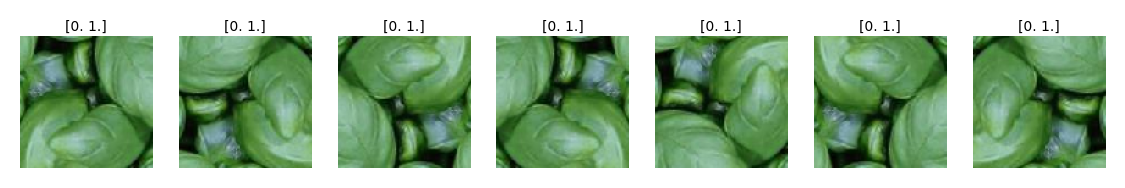

In [47]:
IMGS, LBLS = manual_augmentation(IMGS, LBLS, LBLS_)
plot_images(IMGS[-7:], LBLS[-7:],0,1,7)

In [48]:
print(len(IMGS))
print()

LBLS_ = list(map(lambda x: "unhealthy" if np.argmax(x) else "healthy", LBLS))
print(pd.DataFrame(LBLS_, columns=['class'])['class'].value_counts() )

6117

healthy      3060
unhealthy    3057
Name: class, dtype: int64


In [ ]:
np.savez_compressed("8k.npz", IMGS, LBLS)

In [ ]:
# plot_images(IMGS[-7:], LBLS[-7:], 0, 1, 7)

In [49]:
LIMG = len(IMGS)
LLBL = len(LBLS)

# Split the Data Set into Training XT YT, Validation XV YV, Test XTE YTE
Xtrv, XTE, Ytrv, YTE = train_test_split(
    IMGS,
    LBLS,
    test_size=int(TEST_PERC * LIMG),
    **({"random_state":SEED} if not RND else {}),
    stratify=LBLS
)

XT, XV, YT, YV = train_test_split(
    Xtrv,
    Ytrv,
    test_size=int(VALI_PERC*LIMG),
    **({"random_state":SEED} if not RND else {}),
    stratify=Ytrv
)

# Shapes
print('Training Set Shape: ', XT.shape, YT.shape)
print('Validation Set Shape: ', XV.shape, YV.shape)
print('Test Set Shape: ', XTE.shape, YTE.shape)
print()

# Get the Shape of IN OUT
input_shape = XT.shape[1:]
output_shape = YT.shape[1]                                                        # Enable for MultiClass Problem

print(f'Input shape of the Network: {input_shape}')
print(f'Output shape of the Network: {output_shape}')
print()

Training Set Shape:  (4283, 96, 96, 3) (4283, 2)
Validation Set Shape:  (917, 96, 96, 3) (917, 2)
Test Set Shape:  (917, 96, 96, 3) (917, 2)

Input shape of the Network: (96, 96, 3)
Output shape of the Network: 2



In [50]:
XT, YT = increase_volume_mixup(XT, YT, 2000)

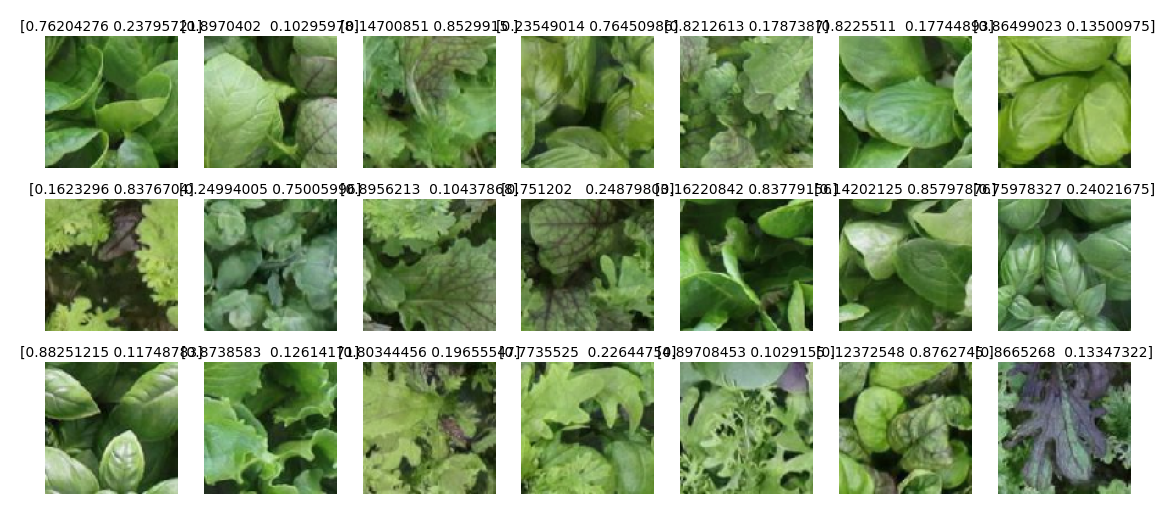

In [51]:
plot_images(XT[-21:], YT[-21:], 0, 3, 7)

In [52]:
LBLS_ = list(map(lambda x: "unhealthy" if np.argmax(x)==0 else "healthy", YT))
print(pd.DataFrame(LBLS_, columns=['class'])['class'].value_counts() )
print()

# Shapes
print('Training Set Shape: ', XT.shape, YT.shape)
print('Validation Set Shape: ', XV.shape, YV.shape)
print('Test Set Shape: ', XTE.shape, YTE.shape)
print()


unhealthy    3142
healthy      3141
Name: class, dtype: int64

Training Set Shape:  (6283, 96, 96, 3) (6283, 2)
Validation Set Shape:  (917, 96, 96, 3) (917, 2)
Test Set Shape:  (917, 96, 96, 3) (917, 2)



In [ ]:
np.savez_compressed("8k.npz", Xtrv, XTE, Ytrv, YTE)

**Augmentation Layers**

In [53]:
# Rescaling
data_rescaling = tkl.Rescaling(scale=1./255)                                      # Normalize the Images from 0..255 to 0..1
data_backscaling = tkl.Rescaling(scale=1.*255)                                    # Normalize the Images from 0..1 to 0..255

data_rescaling_c = tkl.Rescaling(scale=1./127.5, offset=-1)                       # Normalize the Images from 0..255 to -1..1
data_backscaling_c = tkl.Rescaling(scale=1.*127.5, offset=1)                      # Normalize the Images from -1..1 to 0..255

# Agumentation
augm_91 = tkm.Sequential([
    tkl.RandomTranslation(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3)),
    tkl.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2)),
    tkl.RandomFlip('horizontal'),
    tkl.RandomRotation(factor=359)
])

### Training

**Define the Model**

In [54]:
from keras.applications.convnext import preprocess_input

def ae(input_shape, output_shape):

  preprocessing = tfk.Sequential([
      # tkl.RandomContrast(factor=(0,0.3)),
      # tkl.RandomBrightness(factor=(0,0.3)),
      tkl.RandomTranslation(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3)),
      tkl.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2)),
      tkl.RandomFlip('horizontal'),
      tkl.RandomRotation(factor=359)
    ], name='preprocessing'
  )

  res = tfk.applications.ConvNeXtBase(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=2,
    classifier_activation='softmax'
  )
  res.trainable = False

  input_layer = tkl.Input(input_shape)
  # x = data_rescaling_c(input_layer)
  x = preprocess_input(input_layer)
  x = preprocessing(x)
  # x = augm_91(x)
  x = res(x)
  x = tkl.GlobalAveragePooling2D()(x)
  x = tkl.Dense(units=128,activation=tkl.LeakyReLU(alpha=0.3))(x)                 # maybe we have to use leakyrelu
  # x = tkl.BatchNormalization()(x)
  x = tkl.Dropout(0.7)(x)

  # x = tkl.Dense(units=2048,activation='relu')(x)
  # x = tkl.Dense(units=2048,activation='relu')(x)
  # x = tkl.Dense(units=1024,activation='relu')(x)

  output_layer = tkl.Dense(units=output_shape,activation='softmax')(x)
  model =tfk.Model(input_layer, output_layer)

  # Compile the model
  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001),
      metrics=['accuracy']
  )

  return model


**Train the Model**

In [55]:
model = ae(input_shape,output_shape)
BATCH = 32
EPOCHS = 300

# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                                                       # Metric to monitor (validation mean squared error in this case)
    patience=5,                                                                   # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.65,                                                                  # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                                                   # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                                                   # Minimum learning rate
)

callbacks = [early_stopping, lr_scheduler]

history = model.fit(
    x = XT,
    y = YT,
    batch_size = BATCH,
    epochs = EPOCHS,
    validation_data = (XV, YV),
    callbacks = callbacks
).history

Epoch 1/300
197/197 [==============================] - 60s 205ms/step - loss: 0.7456 - accuracy: 0.6505 - val_loss: 0.5606 - val_accuracy: 0.7067 - lr: 0.0010
Epoch 2/300
197/197 [==============================] - 30s 150ms/step - loss: 0.5942 - accuracy: 0.7205 - val_loss: 0.5217 - val_accuracy: 0.7197 - lr: 0.0010
Epoch 3/300
197/197 [==============================] - 31s 157ms/step - loss: 0.5664 - accuracy: 0.7337 - val_loss: 0.4296 - val_accuracy: 0.7874 - lr: 0.0010
Epoch 4/300
197/197 [==============================] - 31s 157ms/step - loss: 0.5457 - accuracy: 0.7495 - val_loss: 0.4506 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 5/300
197/197 [==============================] - 29s 149ms/step - loss: 0.5408 - accuracy: 0.7570 - val_loss: 0.4185 - val_accuracy: 0.8015 - lr: 0.0010
Epoch 6/300
197/197 [==============================] - 31s 156ms/step - loss: 0.5277 - accuracy: 0.7635 - val_loss: 0.4039 - val_accuracy: 0.8004 - lr: 0.0010
Epoch 7/300
197/197 [=========================

### Saving and Plotting

**Test Prediction Accuracy**

In [58]:
test_prediction(model, XTE, YTE)

Accuracy Score over the Test Set: 0.8397



**Plots Loss**

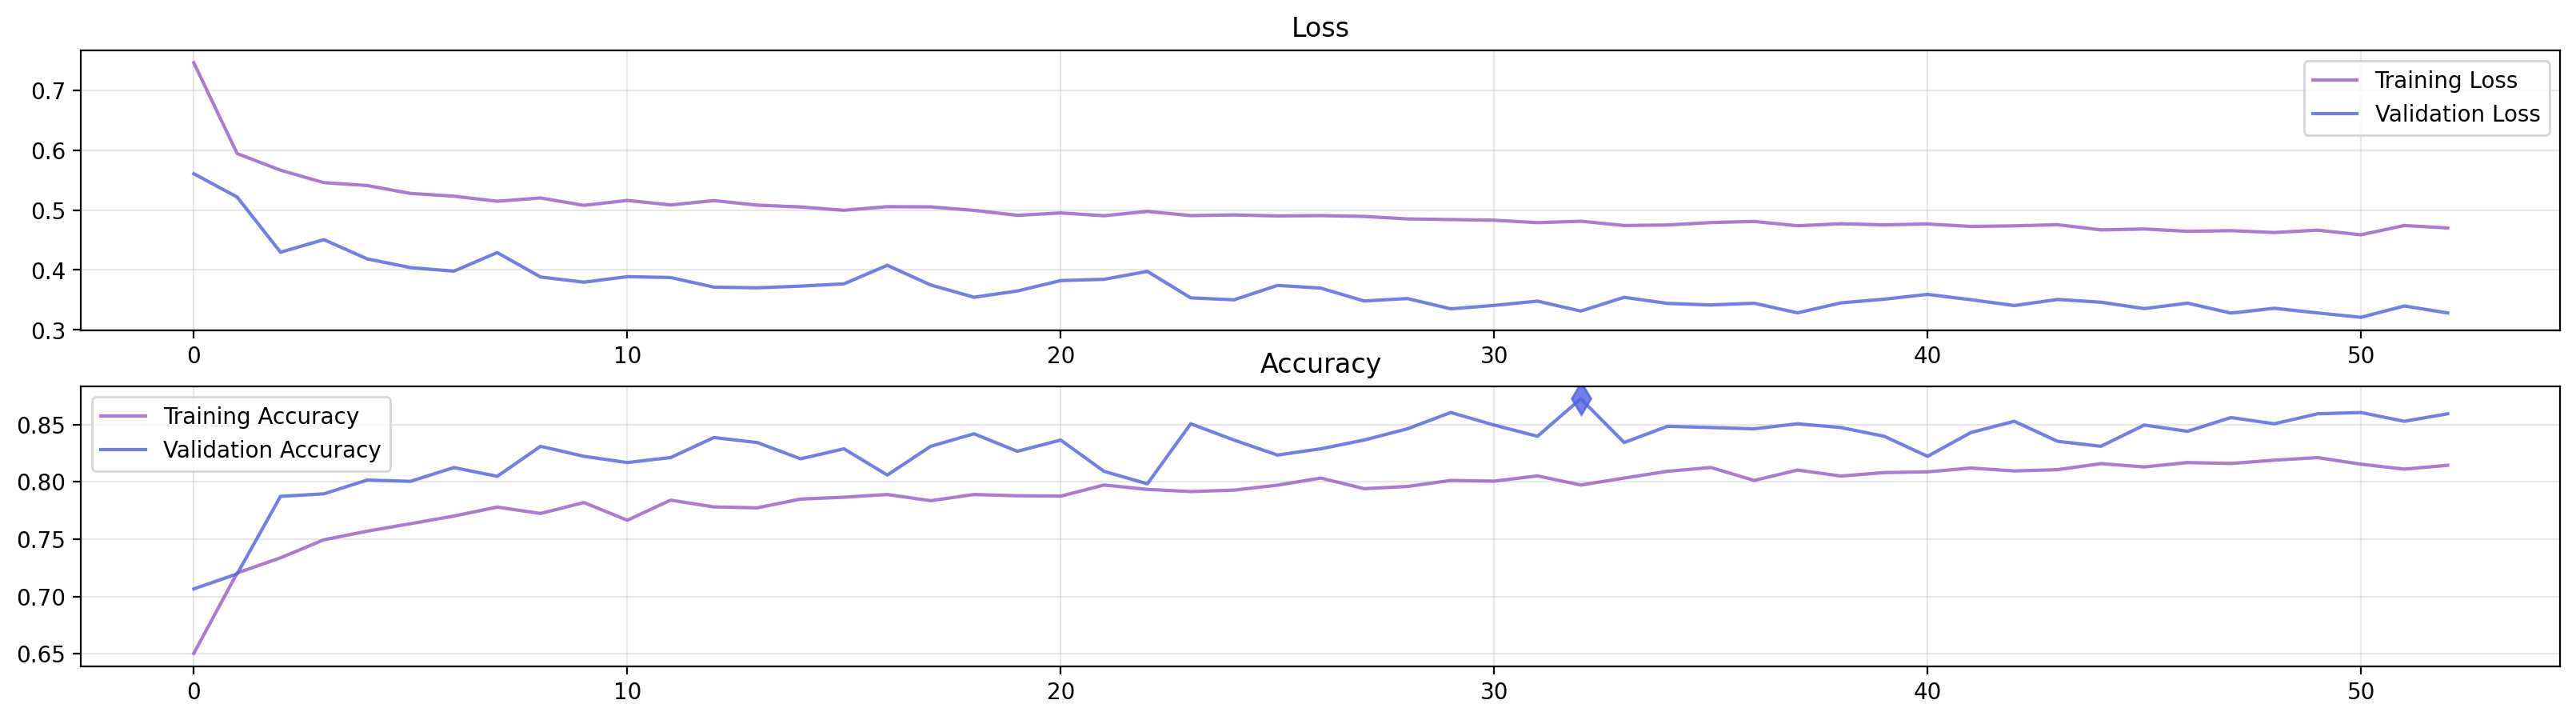

In [59]:
plot_losses(history, (20,5), NAME_PLOT)

**Plot Confusion Matrix**

Accuracy:	 0.8397
Precision:	 0.8407
Recall:		 0.8397
F1:		 0.8396


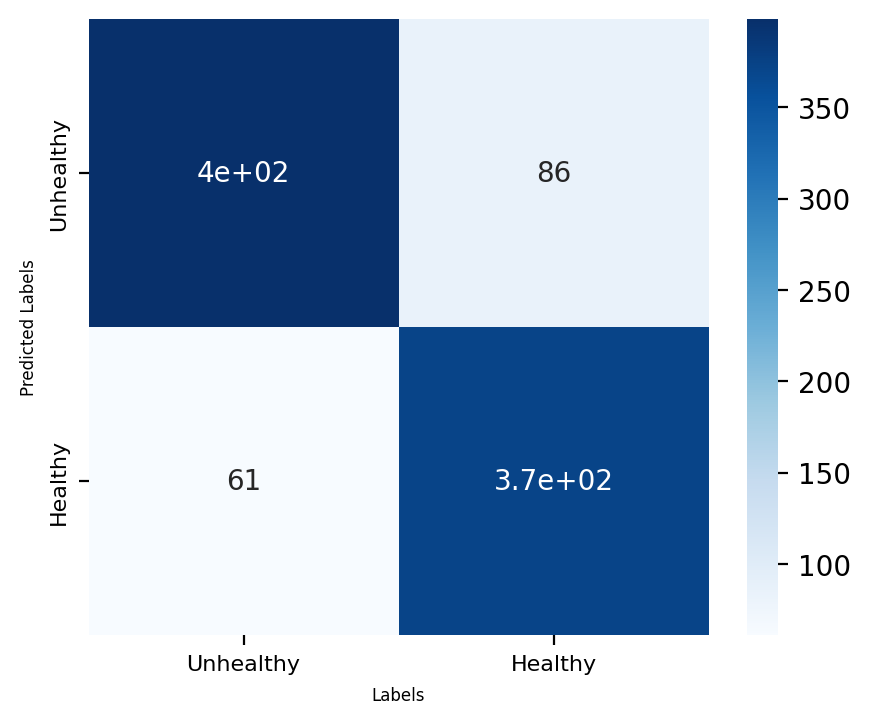

In [60]:
plot_confusion_matrix(model, XTE, YTE, (5,4), NAME_CMATRIX)

**Save the Model**

In [261]:
model.save(NAME_MODEL)

**Zip Model and Plots**

In [ ]:
!zip -r {NAME_MODEL}.zip {NAME_MODEL} {NAME_PLOT}.png {NAME_CMATRIX}.png

  adding: ConvNeXtV2_t002/ (stored 0%)
  adding: ConvNeXtV2_t002/variables/ (stored 0%)
  adding: ConvNeXtV2_t002/variables/variables.index (deflated 77%)
  adding: ConvNeXtV2_t002/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXtV2_t002/saved_model.pb (deflated 92%)
  adding: ConvNeXtV2_t002/fingerprint.pb (stored 0%)
  adding: ConvNeXtV2_t002/keras_metadata.pb (deflated 96%)
  adding: ConvNeXtV2_t002/assets/ (stored 0%)
  adding: ConvNeXtV2_t002_plot.png (deflated 11%)
  adding: ConvNeXtV2_t002_cmatrix.png (deflated 16%)


**Delete the Model**

In [262]:
del model

## Tuning

**Load the Model**

In [263]:
ft_model = tfk.models.load_model(NAME_MODEL)

In [61]:
ft_model = model

**Count the Layers**

In [62]:
ft_model.get_layer('convnext_base').trainable = True
c = 0
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
   c += 1

print("Layers: ",c)
print()

Layers:  295



**Train only the Last Layers**

In [63]:
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:200]):
  layer.trainable=False

ft_model.compile(
  loss=tfk.losses.CategoricalCrossentropy(),
  optimizer=tfk.optimizers.Nadam(learning_rate=0.0001, weight_decay=0.0001),
  metrics=['accuracy']
)

**Train the Tuning Model**

In [64]:
BATCH = 32
EPOCHS = 300

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                                                       # Metric to monitor (validation mean squared error in this case)
    patience=5,                                                                   # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.80,                                                                  # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                                                   # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                                                   # Minimum learning rate
)

callbacks = [early_stopping,lr_scheduler]

history = ft_model.fit(
    x = XT,                                                                       # We need to apply the preprocessing thought for the MobileNetV2 network
    y = YT,
    batch_size = BATCH,
    epochs = EPOCHS,
    validation_data = (XV, YV),                                                   # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = callbacks
).history

Epoch 1/300
197/197 [==============================] - 103s 268ms/step - loss: 0.4755 - accuracy: 0.8084 - val_loss: 0.2671 - val_accuracy: 0.8790 - lr: 1.0000e-04
Epoch 2/300
197/197 [==============================] - 48s 241ms/step - loss: 0.4295 - accuracy: 0.8453 - val_loss: 0.2685 - val_accuracy: 0.8779 - lr: 1.0000e-04
Epoch 3/300
197/197 [==============================] - 46s 235ms/step - loss: 0.3992 - accuracy: 0.8762 - val_loss: 0.2664 - val_accuracy: 0.8953 - lr: 1.0000e-04
Epoch 4/300
197/197 [==============================] - 46s 236ms/step - loss: 0.3779 - accuracy: 0.8849 - val_loss: 0.2321 - val_accuracy: 0.9040 - lr: 1.0000e-04
Epoch 5/300
197/197 [==============================] - 48s 244ms/step - loss: 0.3517 - accuracy: 0.8986 - val_loss: 0.2337 - val_accuracy: 0.9106 - lr: 1.0000e-04
Epoch 6/300
197/197 [==============================] - 46s 235ms/step - loss: 0.3397 - accuracy: 0.9051 - val_loss: 0.2149 - val_accuracy: 0.9138 - lr: 1.0000e-04
Epoch 7/300
197/197 [

### Saving and Plotting

In [65]:
FT_NAME = NAME_MODEL+"_Tuning"
FT_PLOT = NAME_PLOT+"_Tuning"
FT_CMATRIX = NAME_CMATRIX+"_Tuning"

**Test Prediction Accuracy**

In [79]:
tp = test_prediction(ft_model, XTE, YTE)

Accuracy Score over the Test Set: 0.9346



In [1]:
print(len(tp))

_ = list(map(lambda x: "unhealthy" if x == 0 else "healthy", tp))
YT_ = list(map(lambda x: "unhealthy" if np.argmax(x) else "healthy", YT))

err = []
err_lbl = []

for i, lbl in enumerate(tp):
  if lbl != YT_[i]:
    err.append(XT[i])
    err_lbl.append(YT_[i])

plot_images(err, err_lbl, 0, 1, 10)

NameError: ignored

**Plot Loss**

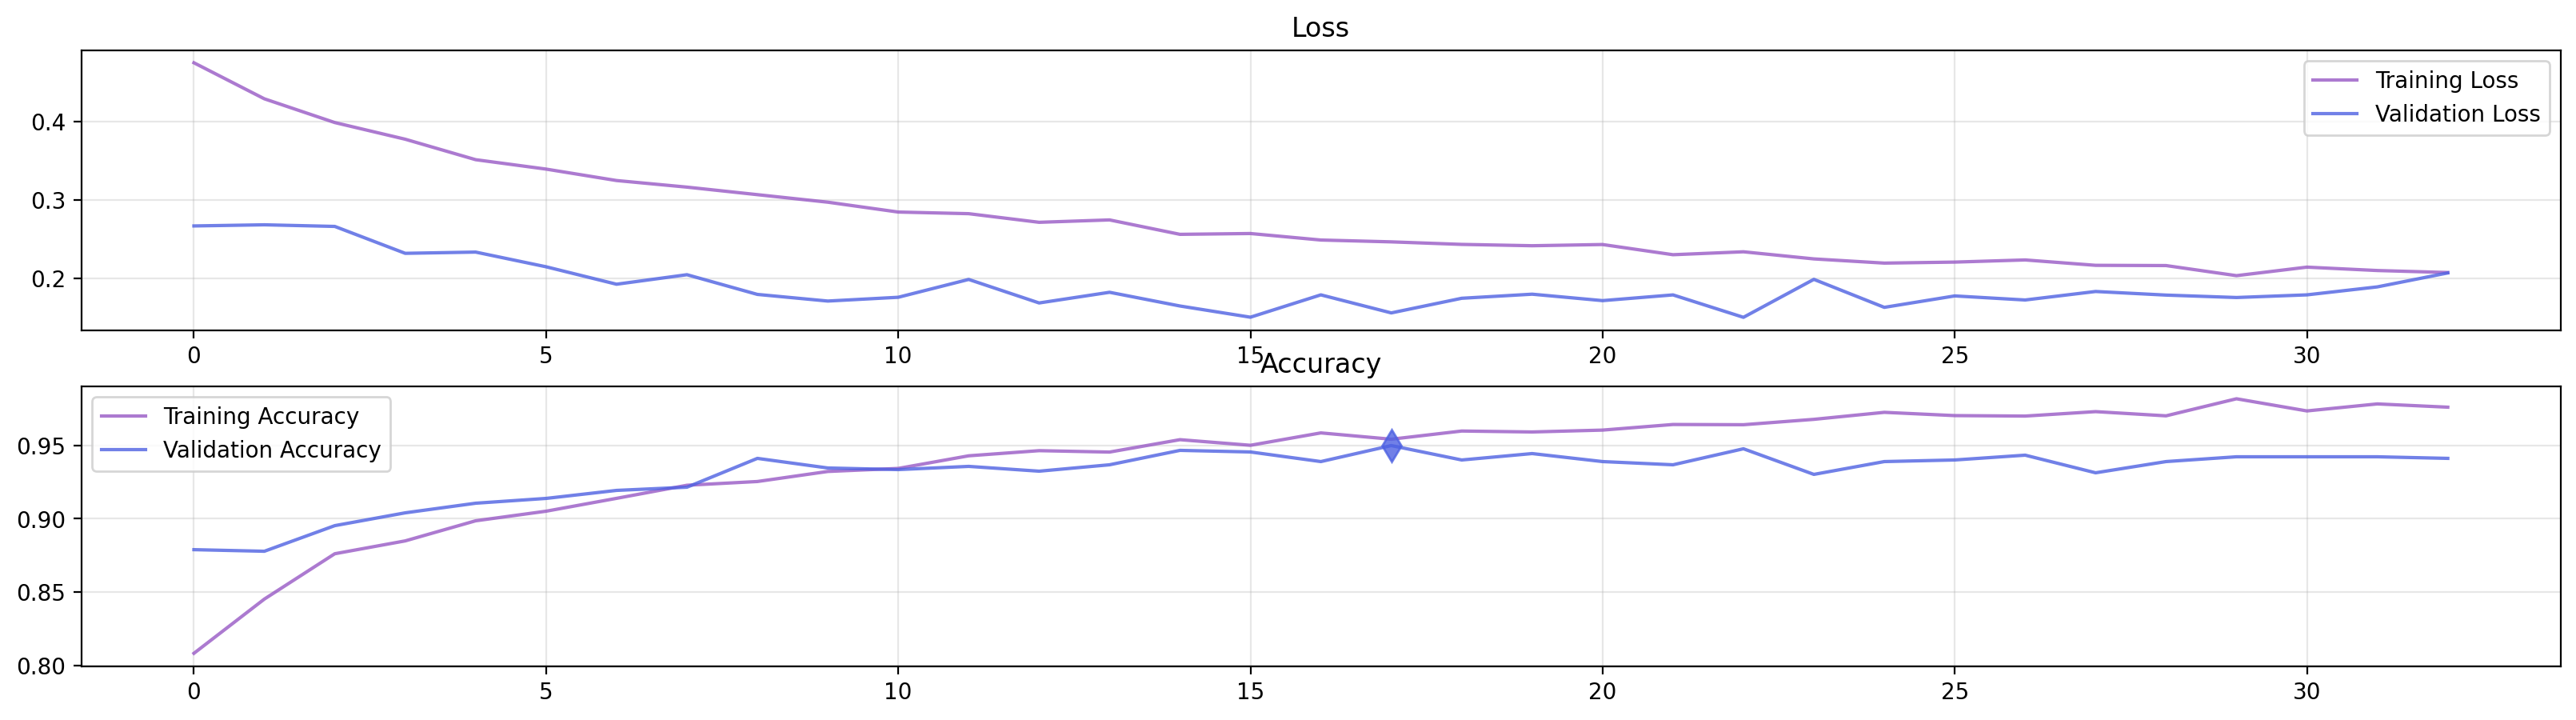

In [67]:
plot_losses(history, (20,5), FT_NAME)

**Plot Confusion Matrix**

Accuracy:	 0.9346
Precision:	 0.9346
Recall:		 0.9346
F1:		 0.9346


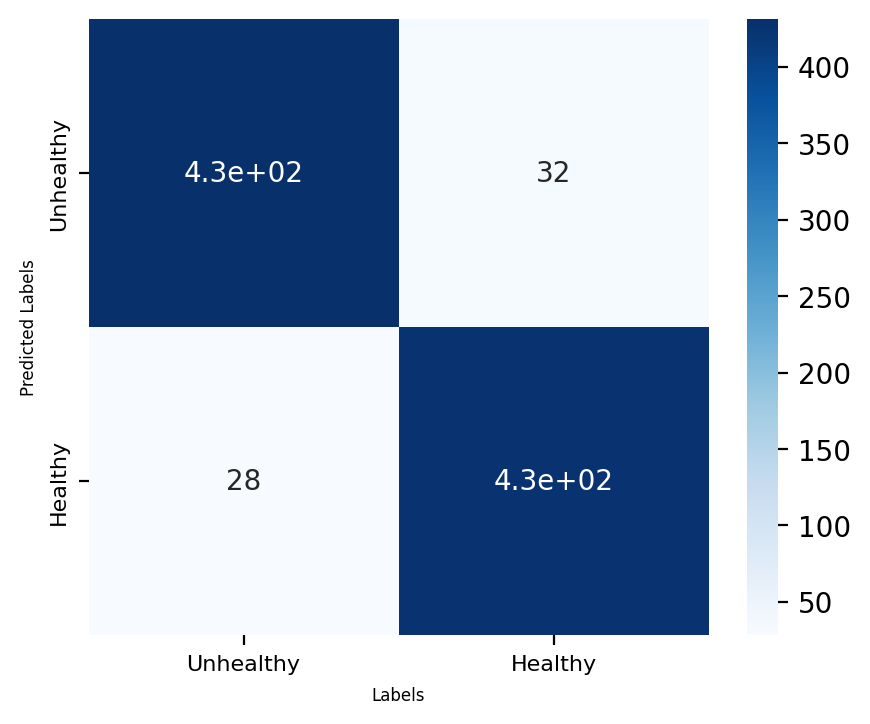

In [68]:
plot_confusion_matrix(ft_model, XTE, YTE, (5,4), NAME_CMATRIX)

**Save the Model**

In [69]:
ft_model.save(NAME_MODEL+"_Tuning")

**Zip the Model and the Plots**

In [70]:
!zip -r {FT_NAME}.zip {FT_NAME} {FT_PLOT}.png {FT_CMATRIX}.png

	zip warning: name not matched: ConvNeXt_8k_plot_Tuning.png
	zip warning: name not matched: ConvNeXt_8k_cmatrix_Tuning.png
  adding: ConvNeXt_8k_Tuning/ (stored 0%)
  adding: ConvNeXt_8k_Tuning/variables/ (stored 0%)
  adding: ConvNeXt_8k_Tuning/variables/variables.index (deflated 78%)
  adding: ConvNeXt_8k_Tuning/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXt_8k_Tuning/saved_model.pb (deflated 92%)
  adding: ConvNeXt_8k_Tuning/fingerprint.pb (stored 0%)
  adding: ConvNeXt_8k_Tuning/keras_metadata.pb (deflated 96%)
  adding: ConvNeXt_8k_Tuning/assets/ (stored 0%)


**Plot Test and Error on Test**

917


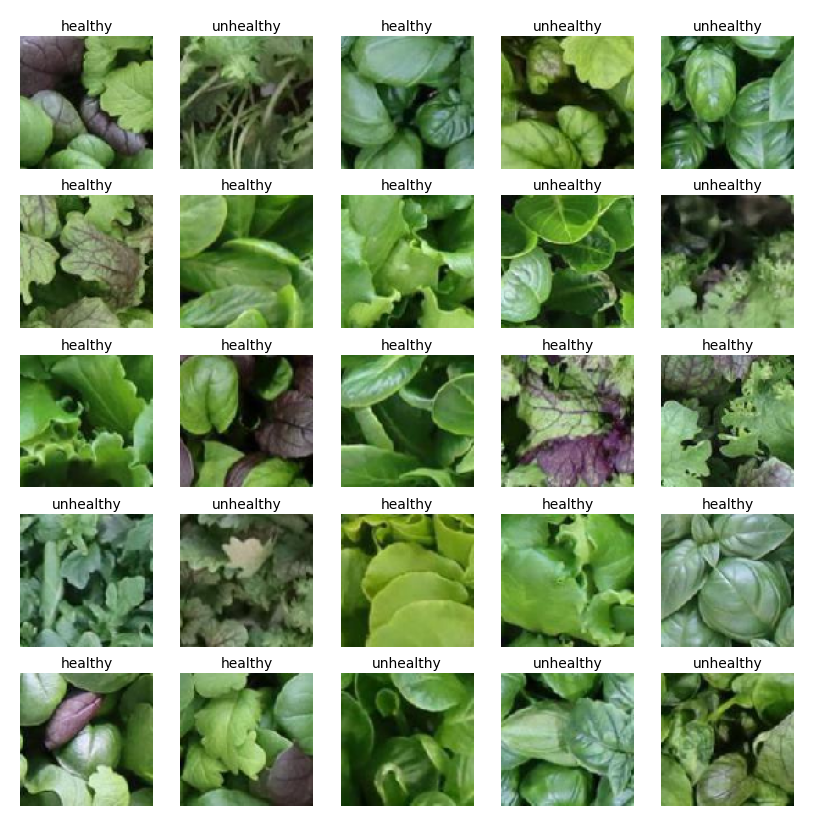

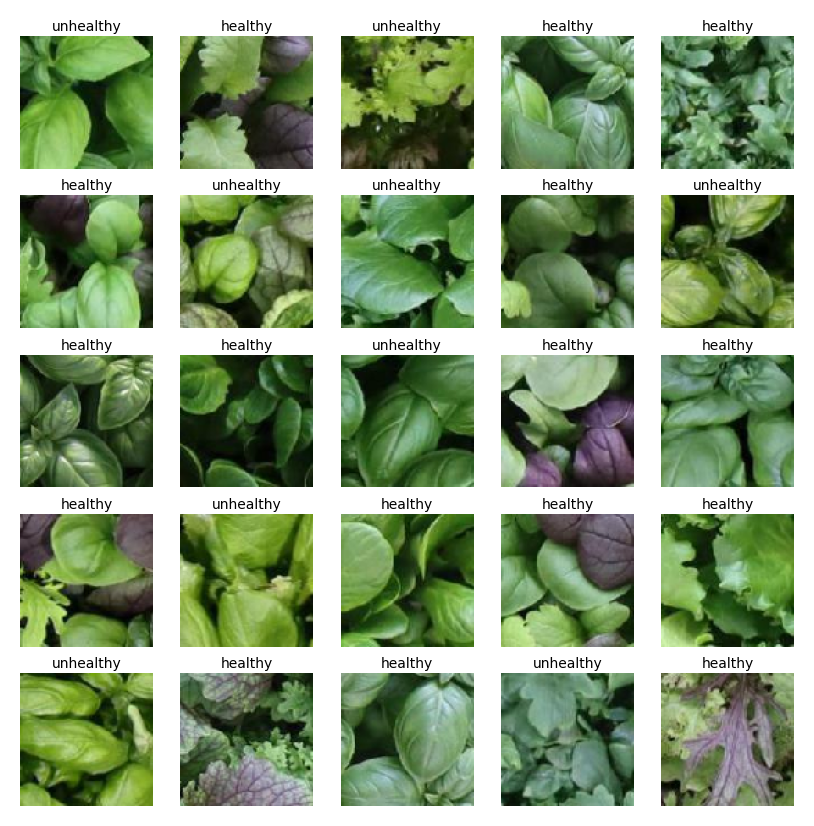

In [71]:
YTE_ = list(map(lambda x: "unhealthy" if x[0]==0. and x[1]==1. else "healthy", YTE))
plot_images(XTE[:25], YTE_[:25], 0, 5, 5)
plot_images(XTE[25:50], YTE_[25:50], 0, 5, 5)

print(len(XTE))